In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np


In [3]:
df = pd.read_csv('abc.es_full.csv')

In [6]:
df

Unnamed: 0  Unnamed: 0.1  \
0              0             0   
1              1             1   
2              2             2   
3              3             3   
4              4             4   
...          ...           ...   
4374        4374          4374   
4375        4375          4375   
4376        4376          4376   
4377        4377          4377   
4378        4378          4378   

                                                    url       fecha  \
0     https://horoscopo.abc.es/signos-zodiaco-aries/...  2020-08-03   
1     https://horoscopo.abc.es/signos-zodiaco-tauro/...  2020-08-03   
2     https://horoscopo.abc.es/signos-zodiaco-gemini...  2020-08-03   
3     https://horoscopo.abc.es/signos-zodiaco-cancer...  2020-08-03   
4     https://horoscopo.abc.es/signos-zodiaco-leo/pr...  2020-08-03   
...                                                 ...         ...   
4374  https://horoscopo.abc.es/signos-zodiaco-escorp...  2019-08-05   
4375  https://horoscopo.abc.es/signos-zodiaco-sagita...  2019-08-05   
4376  https://horoscopo.abc.es/signos-zodiaco-capric...  2019-08-05   
4377  https://horoscopo.abc.es/signos-zodiaco-acuari...  2019-08-05   
4378  https://horoscopo.abc.es/signos-zodiaco-piscis...  2019-08-05   

            signo                                              texto  \
0           aries  Aries, usa la imaginación y la fantasía para l...   
1           tauro  Puedes tener algunos gastos extraordinarios co...   
2         géminis  Te agobiarás si no llevas al día los asuntos d...   
3          cáncer  Puede que te surja algún gasto imprevisto, per...   
4             leo  Tendrás buenas noticias sobre un trabajo que t...   
...           ...                                                ...   
4374     escorpio  El mes de agosto no será el más adecuado para ...   
4375    sagitario  Será un periodo de evolución a nivel profesion...   
4376  capricornio  Descubrirá los primeros días de agosto, una op...   
4377      acuario  Aunque sea una época vacaciones, Acuario deber...   
4378       piscis  Antes de insistir en un proyecto del trabajo p...   

                                              tokenized  
0     {signo}, usa la imaginación y la fantasía para...  
1     Puedes tener algunos gastos extraordinarios co...  
2     Te agobiarás si no llevas al día los asuntos d...  
3     Puede que te surja algún gasto imprevisto, per...  
4     Tendrás buenas noticias sobre un trabajo que t...  
...                                                 ...  
4374  El mes de agosto no será el más adecuado para ...  
4375  Será un periodo de evolución a nivel profesion...  
4376  Descubrirá los primeros días de agosto, una op...  
4377  Aunque sea una época vacaciones, {signo} deber...  
4378  Antes de insistir en un proyecto del trabajo p...  

[4379 rows x 7 columns]

In [7]:
df['tokenized'].apply(len).max()

1156

In [9]:
df['tokenized'].apply(len).mean()

772.7602192281342

<AxesSubplot:ylabel='Frequency'>

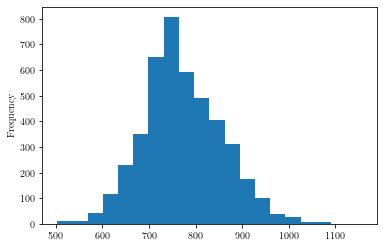

In [13]:
df['tokenized'].apply(len).plot.hist(bins=20)

El objetivo es hacer una Red Neuronal Recursiva (RNN) que tome como entrada una secuencia de texto.
Esto es porque las RNN se enfocan en resolver problemas donde la salida depende de estados anteriores de 
la entrada. Ejemplos son audio, series de tiempo y en este caso texto.


¿Cómo se introduce el texto en una red neuronal?
Para entrenar se crearán secuencias de tamaño fijo, provenientes del texto fuente, donde la 
secuencia $n_t(A,B)$ es la secuencia $t$ que toma desde el caracter con índice secuencial $A$, hasta el carácter
con índice secuencial $B$. La siguiente secuencia se específica por $n_{t+1}(A+k, B+k)$ donde $k$ es un desplazamiento arbitrario, pues el propósito de la RNN será predecir o acompletar la secuencia de texto.

In [16]:
max_len = 60 
k = 3
secuencias = []
next_chars = []
texto = '\n\n'.join(df['tokenized'].tolist())

In [18]:
for seq in range(0, len(texto)-max_len, k):
    secuencias.append(texto[seq : seq+max_len]) # Obtener la secuencia de texto (nuestra entrada de la red)
    next_chars.append(texto[seq + max_len])     # El carácter inmediato posterior a la secuencia de texto (nuestra salida de la red)

In [31]:
# Vectorizar las secuencias de texto para que sean tratables por la red neuronal
chars = sorted(set(texto))
char_indices = dict((char, chars.index(char)) for char in chars)
x = np.zeros((len(secuencias), max_len, len(chars)), dtype=np.bool)
y = np.zeros((len(secuencias), len(chars)), dtype=np.bool)
for i, sentence in enumerate(secuencias):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [32]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Ya que se tiene el set de entrenamiento en formato vecotrizado se empieza a construir la red neuronal

In [29]:
from tensorflow.keras import layers
model = tf.keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(max_len, len(chars))))
model.add(layers.Dense(len(chars), activation="softmax"))

In [34]:
# Compilar y entrenar el modelo
model.compile(loss="categorical_crossentropy", optimizer="adam")

import random
for epoch in range(1, 60):
    model.fit(x, y, batch_size=128)
    start_index = random.randint(0, len(texto) - max_len - 1)
    generated_text = x[start_index: start_index + max_len]
    for i in range(400): #generates 400 length string
        preds = model.predict(generated_text)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]
        generated_text += next_char
        generated_text = generated_text[1:]

8835/8835 [==============================] - 742s 84ms/step - loss: 1.6123


NameError: name 'temperature' is not defined

In [37]:
import random
import sys
for epoch in range(0, 60):
    print("Epoch ", epoch)
    f = open("epoch_{}.txt".format(epoch), "w")
    f.write("Epoch {}\n".format(epoch))
    model.fit(x,y, batch_size=128)
    start_index = random.randint(0, len(texto) - max_len - 1)
    generated_text = texto[start_index: start_index + max_len]
    print('--- Generating with seed: "' + generated_text + '"')
    f.write("Seed {}\n".format(generated_text))
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        f.write("Temperature {}\n".format(temperature))
        #print(generated_text)
        for i in range(400):
            sampled = np.zeros((1, max_len, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            generated_text += next_char
            generated_text = generated_text[1:]
           # sys.stdout.write(next_char)
            f.write(next_char)
    f.close()

Epoch  0
8835/8835 [==============================] - 708s 80ms/step - loss: 0.9947
--- Generating with seed: " debe hacer para tener buenas oportunidades de ampliar sus h"
------ temperature: 0.2
------ temperature: 0.5
------ temperature: 1.0
------ temperature: 1.2
Epoch  1
8835/8835 [==============================] - 696s 79ms/step - loss: 0.9513
--- Generating with seed: "el trabajo. Bajo la conjunción de los astros se acercarán pe"
------ temperature: 0.2
------ temperature: 0.5
------ temperature: 1.0
------ temperature: 1.2
Epoch  2
8835/8835 [==============================] - 691s 78ms/step - loss: 0.9207
--- Generating with seed: "rá, y bajo la posición de los astros podría crearse un víncu"
------ temperature: 0.2
------ temperature: 0.5
------ temperature: 1.0
------ temperature: 1.2
Epoch  3
8835/8835 [==============================] - 745s 84ms/step - loss: 0.8981
--- Generating with seed: "cambiar algunos hábitos. 

Tendrá buenas expectativas en el "
------ temperature: 

<ipython-input-32-66c6eecb696d>:3: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


------ temperature: 0.5
------ temperature: 1.0
------ temperature: 1.2
Epoch  6
8835/8835 [==============================] - 745s 84ms/step - loss: 0.8550
--- Generating with seed: "hacia un nuevo amor de destino. Este estado de confusión pod"
------ temperature: 0.2
------ temperature: 0.5
------ temperature: 1.0
------ temperature: 1.2
Epoch  7
8835/8835 [==============================] - 744s 84ms/step - loss: 0.8453
--- Generating with seed: "erto interés en su pareja o conquista. El cuidado de la piel"
------ temperature: 0.2
------ temperature: 0.5
------ temperature: 1.0
------ temperature: 1.2
Epoch  8
8835/8835 [==============================] - 745s 84ms/step - loss: 0.8366
--- Generating with seed: " que {signo} prospere en el trabajo, será muy favorable si p"
------ temperature: 0.2
------ temperature: 0.5
------ temperature: 1.0
------ temperature: 1.2
Epoch  9
8835/8835 [==============================] - 745s 84ms/step - loss: 0.8292
--- Generating with seed: "diaco tend

8835/8835 [==============================] - 746s 84ms/step - loss: 0.7526
--- Generating with seed: "igno del Zodiaco le hará cambiar ciertas actitudes que le pe"
------ temperature: 0.2
------ temperature: 0.5
------ temperature: 1.0
------ temperature: 1.2
Epoch  37
8835/8835 [==============================] - 744s 84ms/step - loss: 0.7512
--- Generating with seed: " pendiente de los prejuicios de los demás para mantener el é"
------ temperature: 0.2
------ temperature: 0.5
------ temperature: 1.0
------ temperature: 1.2
Epoch  38
8835/8835 [==============================] - 744s 84ms/step - loss: 0.7499
--- Generating with seed: "s que los astros presagian un retroceso en el amor. Liberar "
------ temperature: 0.2
------ temperature: 0.5
------ temperature: 1.0
------ temperature: 1.2
Epoch  39
8835/8835 [==============================] - 745s 84ms/step - loss: 0.7485
--- Generating with seed: "os bajo este signo del Zodiaco hoy se sentirán muy queridos "
------ temperature: 0.2
--

In [38]:
model.save('modelos/single_ltsm')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: modelos/single_ltsm/assets


# Modelo alternativo (GRU)

In [ ]:
model2 = tf.keras.models.Sequential()
model2.add(layers.Embedding(len_(chars), 256)
model2.add(layers.GRU(128, input_shape=(max_len, len(chars))))
model2.add(layers.Dense(len(chars), activation="softmax"))